## Digit Recognizer

## load data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib inline

In [49]:
def read_csv(filename, max_n = 100, header = True): 
    data = np.array([], dtype=np.float32)
    i = 0
    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        if header:
            colnames = np.array(reader.next())
        for row in reader:
            row = np.array(row,dtype = np.float32)
            data = np.append(data,row)
            i+=1
            if i>max_n:
                break
    csvfile.close()
    dim = len(colnames)
    return data.reshape(-1,dim), colnames

## reshape to matix type
## first column is label
data,header = read_csv('./train.csv',max_n=10000)
np.save('train_data.npy',data)

In [83]:
data = np.load('train_data.npy')
Y = data[:,0].astype(np.int8)
X = data[:,1:].astype(np.float32)

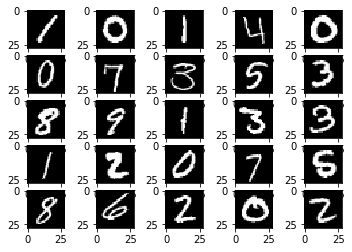

In [44]:
n = 5
fig, subs = plt.subplots(n,n)
k = 0
for i in range(n):
    for j in range(n):
        subs[i,j].imshow(X[k].reshape(28,28), cmap = 'gray')
        k+=1

## 2. Convolve Layer
* 10x10 filters
* stride 2
* dimension reduction 28x28 => 8x8  (28-10)/2+1)

In [18]:
input_size = 28
filter_size = 10
stride = 2
conv = []
for k in range(25):
    img = X[k].reshape(input_size,input_size)
    conved_layer = np.array([])
    conv_filter = np.random.randn(filter_size,filter_size)
    for i in range(0,input_size - filter_size-1,stride):
        for j in range(0,input_size - filter_size-1,stride):
             conved_layer = np.append(conved_layer, np.dot(img[i:(i+filter_size),j:(j+filter_size)],conv_filter).sum())
    conv.append(conved_layer)

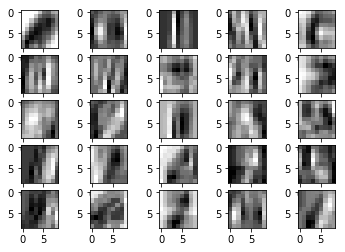

In [19]:
n = 5
fig, subs = plt.subplots(n,n)
k = 0
for i in range(n):
    for j in range(n):
        subs[i,j].imshow(conv[k].reshape(9,9), cmap = 'gray')
        k+=1

In [84]:
import tensorflow as tf

n,dim = X.shape
index = np.arange(n)
np.random.shuffle(index)
cut = 8*n/10
inTrain = index[:cut]
inVal = index[cut:]

X_train = X[inTrain,:]
Y_train = Y[inTrain]
X_val = X[inVal,:]
Y_val = Y[inVal]

In [89]:
x = tf.placeholder(dtype=tf.float32, shape=[None,784])
y = tf.placeholder(dtype = tf.int8, shape= [None])
reg = tf.constant(0.0)

def init_weight(shape):
    return tf.Variable(tf.truncated_normal(dtype=tf.float32, shape = shape, stddev=1e-4), dtype = tf.float32)

def init_bias(shape):
    return tf.Variable(tf.zeros(shape),dtype=tf.float32)

def conv2d(X,W):
    return tf.nn.conv2d(X,W,strides=[1,2,2,1],padding='SAME')

def max_pool_2x2(X):
    return tf.nn.max_pool(X,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

def simple_model(x,y,reg):

    ## init weight and bias
    Wfc1 = init_weight([784,256])
    Bfc1 = init_bias([256])
    Wfc2 = init_weight([256,10])
    Bfc2 = init_bias([10])

    ## two layer nn
    a1 = tf.matmul(x,Wfc1)+Bfc1
    a2 = tf.nn.relu(a1)
    y_out = tf.matmul(a2,Wfc2)+Bfc2
    
    ## get loss
    y_ohe = tf.one_hot(tf.cast(y,tf.int32),10)
    total_loss = tf.losses.softmax_cross_entropy(onehot_labels=y_ohe,logits=y_out)
    mean_loss = tf.reduce_mean(total_loss)
    reg_loss = tf.reduce_mean(tf.square(Wfc1)) + tf.reduce_mean(tf.square(Wfc2))
    loss = mean_loss + reg * reg_loss
    
    ##  get accuracy
    y_ = tf.cast(tf.argmax(y_out,axis=1), tf.int8)
    acc = tf.reduce_mean(tf.cast(tf.equal(y_,y),tf.float32))
    return y_out, loss, acc

y_out,loss, acc = simple_model(x,y,reg)

optimizer = tf.train.AdamOptimizer(1e-3)
train_step = optimizer.minimize(loss)

In [58]:
maxIter = 100
batchSize = 64
n,_ = X_train.shape

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print ('Training')
    for i in range(maxIter):
        inTrain = np.random.choice(n,batchSize)
        batchX = X_train[inTrain,:]
        batchY = Y_train[inTrain]
        train_step.run(feed_dict={x:batchX,y:batchY},session=sess)
        if i%20 ==0:
            iterLoss = loss.eval(feed_dict={x:X_train,y:Y_train,reg:0.1},session=sess)
            iterAcc = acc.eval(feed_dict={x:X_train,y:Y_train,reg:0.1},session=sess)
            print ('iter {0:2d}: loss {1:.3f} acc {2:.3f}').format(i,iterLoss, iterAcc)
            
    print('Validation')
    iterLoss = loss.eval(feed_dict={x:X_val,y:Y_val,reg:0.1},session=sess)
    iterAcc = acc.eval(feed_dict={x:X_val,y:Y_val,reg:0.1},session=sess)
    print('loss {0:.3f} acc {1:.3f}').format(iterLoss, iterAcc)    

Training
iter  0: loss 2.300 acc 0.107
iter 20: loss 0.551 acc 0.836
iter 40: loss 0.316 acc 0.909
iter 60: loss 0.297 acc 0.913
iter 80: loss 0.283 acc 0.911
Validation
loss 0.281 acc 0.918


In [61]:
def run_model(model,X_train,Y_train,X_val,Y_val,lr = 1e-3,Reg = 0.0, maxIter = 200,batchSize = 32):
    n,_ = X_train.shape
    
    x = tf.placeholder(dtype=tf.float32, shape=[None,784])
    y = tf.placeholder(dtype = tf.int8, shape= [None])
    reg = tf.constant(Reg)
    
    y_out,loss, acc = model(x,y,reg)
    optimizer = tf.train.AdamOptimizer(lr)
    train_step = optimizer.minimize(loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print ('Training')
        for i in range(maxIter):
            inTrain = np.random.choice(n,batchSize)
            batchX = X_train[inTrain,:]
            batchY = Y_train[inTrain]
            train_step.run(feed_dict={x:batchX,y:batchY},session=sess)
            if i%100 ==0:
                iterLoss = loss.eval(feed_dict={x:X_train,y:Y_train,reg:0.1},session=sess)
                iterAcc = acc.eval(feed_dict={x:X_train,y:Y_train,reg:0.1},session=sess)
                print ('iter {0:2d}: loss {1:.3f} acc {2:.3f}').format(i,iterLoss, iterAcc)

        print('Validation')
        iterLoss = loss.eval(feed_dict={x:X_val,y:Y_val,reg:0.1},session=sess)
        iterAcc = acc.eval(feed_dict={x:X_val,y:Y_val,reg:0.1},session=sess)
        print('loss {0:.3f} acc {1:.3f}').format(iterLoss, iterAcc)   


## two layer neural network

In [79]:
## define a CNN
def CNN(x,y,reg):
    
    x_fold = tf.reshape(x,[-1,28,28,1])
    
    ## init filters
    Wconv1 = init_weight([5,5,1,32])
    Bconv1 = init_bias([32])

    ## init weight and bias
    Wfc1 = init_weight([6*6*32,1024])
    Bfc1 = init_bias([1024])
    Wfc2 = init_weight([1024,10])
    Bfc2 = init_bias([10])

    ## two layer nn
    a1 = tf.nn.relu(conv2d(x_fold,Wconv1)+Bconv1) #conv1
    a2 = tf.nn.relu(max_pool_2x2(a1)) #maxpool1
    a3 = tf.matmul(tf.reshape(a2,[-1,6*6*32]),Wfc1)+Bfc1 #full-connected 1
    y_out = tf.matmul(a3,Wfc2)+Bfc2 # fully-connected 2
    
    ## get loss
    y_ohe = tf.one_hot(tf.cast(y,tf.int32),10)
    total_loss = tf.losses.softmax_cross_entropy(onehot_labels=y_ohe,logits=y_out)
    mean_loss = tf.reduce_mean(total_loss)
    reg_loss = tf.reduce_mean(tf.square(Wfc1)) + tf.reduce_mean(tf.square(Wfc2))
    loss = mean_loss + reg * reg_loss
    
    ##  get accuracy
    y_ = tf.cast(tf.argmax(y_out,axis=1), tf.int8)
    acc = tf.reduce_mean(tf.cast(tf.equal(y_,y),tf.float32))
    return y_out, loss, acc

In [130]:
x_fold = tf.reshape(x,[-1,28,28,1])
    
## init filters
Wconv1 = init_weight([5,5,1,32])
Bconv1 = init_bias([32])
Wconv2 = init_weight([5,5,32,64])
Bconv2 = init_bias([64])

## init weight and bias
Wfc1 = init_weight([2*2*64,1024])
Bfc1 = init_bias([1024])
Wfc2 = init_weight([1024,10])
Bfc2 = init_bias([10])

## two layer nn
a1 = tf.nn.relu(conv2d(x_fold,Wconv1)+Bconv1) #conv1
a2 = (max_pool_2x2(a1)) #maxpool1
a3 = tf.nn.relu(conv2d(a2,Wconv2)+Bconv2) #conv1
a4 = (max_pool_2x2(a3)) #maxpool1
a5 = tf.reshape(a4,[-1,2*2*64])
a6 = tf.nn.relu(tf.matmul(a5,Wfc1)+Bfc1) #full-connected 1
y_out = tf.matmul(a6,Wfc2)+Bfc2 # fully-connected 2



In [131]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_out.eval(feed_dict = {x:X,y:Y,reg:0.3})

In [132]:
def deep_CNN(x,y,reg = 0.3):
    
    x_fold = tf.reshape(x,[-1,28,28,1])
    
    ## init filters
    Wconv1 = init_weight([5,5,1,32])
    Bconv1 = init_bias([32])
    Wconv2 = init_weight([5,5,32,64])
    Bconv2 = init_bias([64])

    ## init weight and bias
    Wfc1 = init_weight([2*2*64,1024])
    Bfc1 = init_bias([1024])
    Wfc2 = init_weight([1024,10])
    Bfc2 = init_bias([10])

    ## two layer nn
    a1 = tf.nn.relu(conv2d(x_fold,Wconv1)+Bconv1) #conv1
    a2 = (max_pool_2x2(a1)) #maxpool1
    a3 = tf.nn.relu(conv2d(a2,Wconv2)+Bconv2) #conv1
    a4 = (max_pool_2x2(a3)) #maxpool1
    a5 = tf.reshape(a4,[-1,2*2*64])
    a6 = tf.nn.relu(tf.matmul(a5,Wfc1)+Bfc1) #full-connected 1
    y_out = tf.matmul(a6,Wfc2)+Bfc2 # fully-connected 2
    
    ## get loss
    y_ohe = tf.one_hot(tf.cast(y,tf.int32),10)
    total_loss = tf.losses.softmax_cross_entropy(onehot_labels=y_ohe,logits=y_out)
    mean_loss = tf.reduce_mean(total_loss)
    reg_loss = tf.reduce_mean(tf.square(Wfc1)) + tf.reduce_mean(tf.square(Wfc2))
    loss = mean_loss + reg * reg_loss
    
    ##  get accuracy
    y_ = tf.cast(tf.argmax(y_out,axis=1), tf.int8)
    acc = tf.reduce_mean(tf.cast(tf.equal(y_,y),tf.float32))
    return y_out, loss, acc

In [85]:
run_model(simple_model, X_train, Y_train, X_val, Y_val,lr=1e-3, maxIter=2000,batchSize=256,Reg=0.3)

Training
iter  0: loss 2.271 acc 0.099
iter 100: loss 0.146 acc 0.956
iter 200: loss 0.096 acc 0.971
iter 300: loss 0.077 acc 0.975
iter 400: loss 0.066 acc 0.980
iter 500: loss 0.061 acc 0.981
iter 600: loss 0.043 acc 0.986
iter 700: loss 0.066 acc 0.980
iter 800: loss 0.059 acc 0.982
iter 900: loss 0.041 acc 0.987
iter 1000: loss 0.049 acc 0.985
iter 1100: loss 0.055 acc 0.985
iter 1200: loss 0.044 acc 0.988
iter 1300: loss 0.050 acc 0.987
iter 1400: loss 0.038 acc 0.988
iter 1500: loss 0.045 acc 0.987
iter 1600: loss 0.029 acc 0.991
iter 1700: loss 0.046 acc 0.987
iter 1800: loss 0.055 acc 0.987
iter 1900: loss 0.029 acc 0.993
Validation
loss 0.321 acc 0.964


In [86]:
run_model(CNN, X_train, Y_train, X_val, Y_val,lr=1e-3, maxIter=2000,batchSize=256,Reg=0.3)

Training
iter  0: loss 2.300 acc 0.148
iter 100: loss 0.098 acc 0.968
iter 200: loss 0.059 acc 0.982
iter 300: loss 0.047 acc 0.986
iter 400: loss 0.046 acc 0.986
iter 500: loss 0.058 acc 0.982
iter 600: loss 0.049 acc 0.984
iter 700: loss 0.054 acc 0.983
iter 800: loss 0.050 acc 0.984
iter 900: loss 0.053 acc 0.984
iter 1000: loss 0.056 acc 0.983
iter 1100: loss 0.051 acc 0.985
iter 1200: loss 0.036 acc 0.989
iter 1300: loss 0.046 acc 0.986
iter 1400: loss 0.036 acc 0.989
iter 1500: loss 0.039 acc 0.989
iter 1600: loss 0.093 acc 0.977
iter 1700: loss 0.057 acc 0.984
iter 1800: loss 0.065 acc 0.984
iter 1900: loss 0.048 acc 0.988
Validation
loss 0.199 acc 0.967


In [133]:
run_model(deep_CNN, X_train, Y_train, X_val, Y_val,lr=1e-3, maxIter=2000,batchSize=256,Reg=0.3)

Training
iter  0: loss 2.303 acc 0.103
iter 100: loss 0.340 acc 0.898
iter 200: loss 0.138 acc 0.959
iter 300: loss 0.112 acc 0.965
iter 400: loss 0.089 acc 0.972
iter 500: loss 0.068 acc 0.979
iter 600: loss 0.052 acc 0.984
iter 700: loss 0.052 acc 0.984
iter 800: loss 0.054 acc 0.983
iter 900: loss 0.031 acc 0.990
iter 1000: loss 0.025 acc 0.993
iter 1100: loss 0.028 acc 0.991
iter 1200: loss 0.033 acc 0.989
iter 1300: loss 0.029 acc 0.991
iter 1400: loss 0.020 acc 0.994
iter 1500: loss 0.013 acc 0.997
iter 1600: loss 0.018 acc 0.994
iter 1700: loss 0.016 acc 0.995
iter 1800: loss 0.011 acc 0.996
iter 1900: loss 0.024 acc 0.992
Validation
loss 0.073 acc 0.983
